<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_LEGAL_BERT_BASE_HF_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facts extraction with AILA data and LEGAL-BERT-BASE
### Hugging Face version

The model is evaluated through a cross-validation but this notebook doesn't perform the hole cross-validation process. Instead, it runs just one fold of the cross-validation. The fold to be used is indicated by the ``fold_id`` variable.

The implementation is centered on the Hugging Face library.

We use the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;

LEGAL-BERT is available at https://huggingface.co/nlpaueb/legal-bert-base-uncased.


### Notebook parameters

In [1]:
model_id = 'nlpaueb/legal-bert-base-uncased'
model_reference = 'legal-bert-base'
fold_id = 0

### Installing dependencies

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 34.7 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 32.5 MB/s 
     |████████████████████████████████| 212 kB 69.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
     |████████████████████████████████| 140 kB 71.3 MB/s 
     |████████████████████████████████| 127 kB 74.7 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 56.4 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 112 kB 66.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
  Attempting uni

### Random numbers' seed

In [6]:
import random
import numpy as np
import torch

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Loading dataset

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = '/content/gdrive/MyDrive/'
dataset_dir = 'fact_extraction_AILA/'

Mounted at /content/gdrive


In [8]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}{dataset_dir}/train.tar.xz -C data/train

train_dir = 'data/train/'

rm: cannot remove 'data': No such file or directory


In [9]:
from os import listdir
import pandas as pd
import csv

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        quoting=csv.QUOTE_NONE, 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_dic = read_docs(train_dir)

print('Number of documents:', len(docs_dic))

Number of documents: 50


In [10]:
df_folds = pd.read_csv(
  g_drive_dir + dataset_dir + 'train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  if row['fold id'] == fold_id:
    train_files = row['train'].split(',')
    test_files = row['test'].split(',')

print('Train documents: ', train_files)
print('Test documents: ', test_files)

Train documents:  ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt']
Test documents:  ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']


In [12]:
def get_data(doc_ids):
  sentences = []
  labels = []
  for id in doc_ids:
    df = docs_dic[id]
    sentences.extend(df['sentence'].to_list())
    labels.extend(df['label'].to_list())
  return {'sentences': sentences, 'labels': labels}

dic_train = get_data(train_files)
dic_test = get_data(test_files)

In [13]:
print('Training numbers:')
print(f' Total number of sentences: {len(dic_train["sentences"])}')
print(f' Number of Facts labels: {len([l for l in dic_train["labels"] if l == "Facts"])}')
print(f' Number of Other labels: {len([l for l in dic_train["labels"] if l == "Other"])}')

Training numbers:
 Total number of sentences: 7693
 Number of Facts labels: 1584
 Number of Other labels: 6109


### Tokenizer and Dataset preparation

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
max_sentence_length = 425 # about max_tokens_per_sentence + 10%

In [16]:
from datasets import Dataset

def tokenize_function(ds):
  return tokenizer(ds['sentence'], padding='max_length', truncation=True, max_length=max_sentence_length)

def create_dataset(dic_data):
  dic_ = {
      'label' : [1 if s == 'Facts' else 0 for s in dic_data['labels']], 
      'sentence' : dic_data['sentences']
  }
  ds = Dataset.from_dict(dic_)
  ds = ds.map(tokenize_function, batched=True)
  ds.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
  return ds

ds_train = create_dataset(dic_train)
ds_test = create_dataset(dic_test)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
ds_train

Dataset({
    features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7693
})

### Evaluation function

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

best_metrics = {'f1' : -1000}
metrics_by_epoch = []

def evaluate(eval_predictions):
  logits, target_ids = eval_predictions
  predicted_ids = np.argmax(logits, axis=-1)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    target_ids, 
    predicted_ids, 
    average='binary', 
    pos_label=1, 
    zero_division=0)
  # Confusion matrix
  cm = confusion_matrix(
    target_ids, 
    predicted_ids)

  metrics = {
      'precision' : t_metrics[0], 
      'recall' : t_metrics[1], 
      'f1' : t_metrics[2], 
      'cm' : cm
  }
  metrics_by_epoch.append(metrics)

  global best_metrics
  if metrics['f1'] > best_metrics['f1']:
    best_metrics = metrics
  
  return {
      'precision' : t_metrics[0], 
      'recall' : t_metrics[1], 
      'f1' : t_metrics[2]
  }


### Model and fine-tuning

In [20]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [21]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir='checkpoints', 
  overwrite_output_dir=True,
  num_train_epochs=5, 
  per_device_train_batch_size=8, 
  per_device_eval_batch_size=8, 
  evaluation_strategy='epoch', 
  save_strategy='no', 
  save_total_limit=1,
  metric_for_best_model='f1', 
  greater_is_better=True, 
  load_best_model_at_end=False
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=ds_train,
  eval_dataset=ds_test, 
  compute_metrics=evaluate
)

In [22]:
%%time
# Cheking model's performance before fine-tuning
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1687
  Batch size = 8


CPU times: user 47.4 s, sys: 134 ms, total: 47.6 s
Wall time: 47.5 s


{'eval_f1': 0.3201407211961302,
 'eval_loss': 0.695831298828125,
 'eval_precision': 0.36254980079681276,
 'eval_recall': 0.2866141732283465,
 'eval_runtime': 47.507,
 'eval_samples_per_second': 35.511,
 'eval_steps_per_second': 4.441}

In [23]:
%%time

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7693
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4810


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.520300,0.790636,0.000000,0.000000,0.000000
2,0.518400,0.801616,0.000000,0.000000,0.000000
3,0.515600,0.747448,0.000000,0.000000,0.000000
4,0.517200,0.803071,0.000000,0.000000,0.000000
5,0.516600,0.773959,0.000000,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1687
  Batch size = 8


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1687
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1687
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1687
  Batch s

CPU times: user 50min 11s, sys: 6min 50s, total: 57min 1s
Wall time: 57min 12s


TrainOutput(global_step=4810, training_loss=0.5178396784094416, metrics={'train_runtime': 3432.5825, 'train_samples_per_second': 11.206, 'train_steps_per_second': 1.401, 'total_flos': 8400861067147500.0, 'train_loss': 0.5178396784094416, 'epoch': 5.0})

### Best metrics

Precision: 0.3625
Recall:    0.2866
F-score:   0.3201


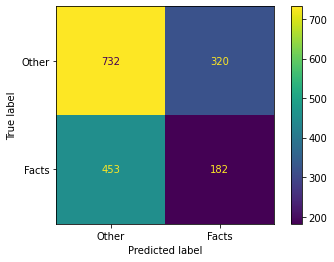

In [24]:
print(f'Precision: {best_metrics["precision"]:.4f}')
print(f'Recall:    {best_metrics["recall"]:.4f}')
print(f'F-score:   {best_metrics["f1"]:.4f}')
ConfusionMatrixDisplay(best_metrics['cm'], display_labels=['Other', 'Facts']).plot()

### References

- I. Chalkidis, M. Fergadiotis, P. Malakasiotis, N. Aletras and I. Androutsopoulos. **"LEGAL-BERT: The Muppets straight out of Law School"**. In Findings of Empirical Methods in Natural Language Processing (EMNLP 2020) (Short Papers), to be held online, 2020. (https://aclanthology.org/2020.findings-emnlp.261)
- Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).